<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Updated property [core/project].


In [2]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
auth.authenticate_user()

In [4]:
# !gcloud config set project {'hackathon-352519'}

In [5]:
#filename = "train-data_all-train-events.zip"
filename = "train-data-2022062020220626.zip"

In [6]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-data-2022062020220626.zip...
- [1 files][192.2 MiB/192.2 MiB]                                                
Operation completed over 1 objects/192.2 MiB.                                    


In [7]:
trains = {}
i = 1
# prevLoco = ''
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                # prevLoco != currentLoco and 
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    # trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      current_time = datetime.now().strftime("%H:%M:%S")
                      print(i, " ", current_time)
                    # prevLoco = currentLoco
                            

1000   00:37:12
2000   00:37:22
3000   00:37:34
4000   00:37:41
5000   00:37:47
6000   00:37:52
7000   00:37:58
8000   00:38:05
9000   00:38:10
10000   00:38:15
11000   00:38:21
12000   00:38:27
13000   00:38:34
14000   00:38:38
15000   00:38:45
16000   00:38:49
17000   00:38:56
18000   00:39:00
19000   00:39:08
20000   00:39:13
21000   00:39:18
22000   00:39:25
23000   00:39:29
24000   00:39:33
25000   00:39:41
26000   00:39:45
27000   00:39:50
28000   00:39:59
29000   00:40:03
30000   00:40:08
31000   00:40:16
32000   00:40:21
33000   00:40:25


In [8]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [9]:
del trains

In [10]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33632 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            33632 non-null  object 
 1   positionHistoryList                                            33632 non-null  object 
 2   locomotiveList                                                 33632 non-null  object 
 3   subdivisionList                                                33632 non-null  object 
 4   trainEstimatedPositionList                                     33632 non-null  object 
 5   trainActualPositionList                                        33632 non-null  object 
 6   trainId.trainSCAC                                              33632 non-null  object 
 7   trainId.trainSection                                          

In [11]:
dfTrainsLearn = dfTrainsAll

In [12]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)
# print(dfTrainsLearn['trailingTonnage'].unique())

In [13]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

In [14]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

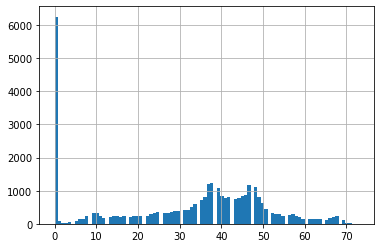

In [15]:
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

In [16]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

In [17]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
print(dfTrainsLearn['symbolType'].unique())

['A' 'Q' 'M' 'H' 'G' 'U' 'O' 'I' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W']


In [18]:
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].astype('category')
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].cat.set_categories(['WEST MAIN', 'MAIN', 'MT 2', 'MT 1', 'WESTXO', 'XO', 'EASTXO','YD LD', 'EAST MAIN', 'TO_N_EAST MAIN', 'TO_S_UP_MAINLINE', 'TO_S_CS JUNCTION', 'S_STARKS', 'TO_S_KCS UP PRT CONN', 'TO_N_LUCAS', 'S_LUCAS'])
#dfTrainsLearn['lastReportedSpeedMPH'] = dfTrainsLearn.apply(lambda row: row['positionHistoryList'][0]['speedMPH'], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].astype('category')
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].cat.set_categories(['A' 'Q' 'M' 'H' 'G' 'U' 'O' 'I' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W'])


In [19]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[88. 50. 60. 70. 40. 45.]


In [20]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [21]:
# routeLoca = dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].str.len() > 0]['aotuTrainData.routeLocationList']
# route = routeLoca.iloc[0]
# print(route)
# jsroute = pd.json_normalize(route)
# jsroute

In [22]:
# dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].map(len)==0]
# dfTrainsLearn[dfTrainsLearn['aotuTrainData.routeLocationList'].apply(lambda x: isinstance(x, float))]['aotuTrainData.routeLocationList']

In [23]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [24]:
dfTrainsLearn['workLocations'].unique()

array([None, '225.10', '202.20', '202.20,219.70', '250.50,202.20', '258.40,202.20', '202.20,258.40,321.50', '202.20,258.40', '219.70,202.20', '202.20,314.52', '202.20,214.50,225.10,290.80,304.10',
       '214.50,225.10,290.80,304.10,202.20', '321.50,202.20', '321.50,314.52,202.20', '258.40,219.70,202.20', '314.52,202.20', '258.40,207.60,202.20', '257.60,202.20', '202.20,265.30',
       '202.20,258.40,318.90,321.50', '202.20,258.40,321.50,219.70', '202.20,219.70,258.40,321.50', '202.20,219.70,250.50,258.40,321.50', '202.20,219.70,258.40', '225.10,202.20'], dtype=object)

We can make this more clever later, but for now this seems the most sensible shortcut

In [25]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

In [26]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [27]:
dfTrainsLearnActuals.iloc[1]

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-06-20T21:45:28Z,11,106,MAIN,765.4883
1,2022-06-20T21:47:28Z,14,106,MAIN-WEST MAIN,765.9972


In [28]:
dfTrainsBeop =  dfTrainsLearn[['lastReportedPosition.milepostLocation.milepost.milepostNumber','trainEstimatedPositionList']]
dfTrainsBeop

,lastReportedPosition.milepostLocation.milepost.milepostNumber,trainEstimatedPositionList
0,764.8696,[]
0,764.9866,[]
0,764.9949,[]
0,764.8691,[]
0,764.9876,[]
...,...,...
0,318.4505,"[{'positionTime': '2022-06-23T11:50:55Z', 'speedMPH': 43, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 318.4505}}}, {'positionTime': '2022-06-23T11:52:55Z', 'speedMPH': 43, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 319.75415}}}, {'positionTime': '2022-06-23T11:54:55Z', 'speedMPH': 43, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 321.19598}}}, {'positionTime': '2022-06-23T11:56:55Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106..."
0,319.5837,"[{'positionTime': '2022-06-23T11:52:29Z', 'speedMPH': 42, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 319.5837}}}, {'positionTime': '2022-06-23T11:54:29Z', 'speedMPH': 42, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 320.99207}}}, {'positionTime': '2022-06-23T11:56:29Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 322.33743}}}, {'positionTime': '2022-06-23T11:58:29Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106..."
0,321.3070,"[{'positionTime': '2022-06-23T11:55:08Z', 'speedMPH': 38, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 321.307}}}, {'positionTime': '2022-06-23T11:57:08Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 322.63477}}}, {'positionTime': '2022-06-23T11:59:08Z', 'speedMPH': 48, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 324.12238}}}, {'positionTime': '2022-06-23T12:01:08Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106,..."
0,322.5925,"[{'positionTime': '2022-06-23T11:57:09Z', 'speedMPH': 38, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 322.5925}}}, {'positionTime': '2022-06-23T11:59:09Z', 'speedMPH': 46, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 323.9869}}}, {'positionTime': '2022-06-23T12:01:09Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 325.62582}}}, {'positionTime': '2022-06-23T12:03:09Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106,..."


In [29]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

In [30]:
def findNextMilepost(trainsEntry, actualsEntry):
  currMilepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > currMilepost+1]
  if (len(value) > 0) :
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].min()]
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < currMilepost-1]
  if (len(value) > 0):
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].max()]
  return []

In [31]:
def findNextSpeed(trainsEntry, actualsEntry):
  nextActual = findNextMilepost(trainsEntry, actualsEntry)
  if (len(nextActual) > 0):
    amt = (abs(nextActual.iloc[0]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
    return amt;
  return None

In [32]:
idx = 3291
print(dfTrainsLearn.iloc[idx]['ptcLeadLocomotiveId'])
print(dfTrainsLearn.iloc[idx]['trainId.trainSymbol'])
print("Reported speed: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.speedMPH'])
print("Reported MP: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])
print("Reported Time: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.positionTime'])

nextActual = findNextMilepost(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx])
print(nextActual)
nextSpeed = findNextSpeed(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx])
print("actual speed: ",nextSpeed)
beopJSON = dfTrainsBeop.iloc[idx]['trainEstimatedPositionList']
if not type(beopJSON) is float and len(beopJSON) > 0:
  beopDT = pd.json_normalize(beopJSON)
  nextBeop = findNextMilepost(dfTrainsLearn.iloc[idx], beopDT)
  print(nextBeop)
  type(dfTrainsBeop.iloc[idx]['trainEstimatedPositionList'])
  print("beop speed: ")
  value = findNextSpeed(dfTrainsLearn.iloc[idx], beopDT)
  print(value)
#   print('na')

UP2533
CWSWT9
Reported speed:  49
Reported MP:  283.9285
Reported Time:  2022-06-23T11:11:58Z
           positionTime  speedMPH  milepostLocation.subdivisionId  \
0  2022-06-23T11:13:58Z        52                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
0                       MT 1                                 285.63345  
actual speed:  3
           positionTime  speedMPH  milepostLocation.subdivisionId  \
1  2022-06-23T11:13:58Z        58                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
1                       MT 1                                 285.68976  
beop speed: 
9


In [33]:
dfTrainsLearn['nextSpeed'] = np.NaN
dfTrainsLearn['nextBeop'] = np.NaN
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  nextSpeed = findNextSpeed(trainsEntry, dfTrainsLearnActuals.iloc[i])
  if (nextSpeed != None):
    dfTrainsLearn.at[i,'nextSpeed'] = nextSpeed
  beopJSON = dfTrainsBeop.iloc[i]['trainEstimatedPositionList']
  if not type(beopJSON) is float and len(beopJSON) > 0:
    try:
      beopDT = pd.json_normalize(beopJSON)
      nextBeop = findNextSpeed(trainsEntry, beopDT)
      if (nextBeop != None):
        dfTrainsLearn.at[i,'nextBeop'] = nextSpeed
    except NotImplementedError:
      print(type(beopJSON))
    except KeyError:
      print(beopJSON)
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000


In [34]:
dfTrainsLearn['nextSpeed'].unique()

array([ nan,   4.,   9.,   8.,   2.,  -1.,  -4.,  -3.,  -2.,   1.,   0.,   3.,   6.,  10.,  13.,  11.,  15.,  12.,   5.,  16.,  21.,  14.,  17., -13.,  22.,  18.,  24.,  20.,  -7., -17.,  -6., -10.,
         7.,  -5., -11.,  25.,  27., -21.,  19., -19.,  -8.,  23.,  32.,  36., -12.,  -9., -22., -20., -14., -23.,  29.,  28., -26., -15., -18.,  26., -25.,  31.,  30., -41.,  34.,  33.,  40.,  38.,
        37., -33., -34., -16.,  41., -24.,  35., -28., -30.,  39.,  44.,  45.,  46., -32., -36.,  49.,  42.,  68.,  52.,  53., -31., -27., -40.,  43.,  50., -43.,  63., -29.,  48., -45.,  69.,  65.,
       -39., -35., -49., -55., -42., -38.,  51., -37., -47.])

In [35]:
dfTrainsLearn = dfTrainsLearn.dropna(subset=['nextSpeed'])
dfTrainsLearn['nextSpeed'].unique()

array([  4.,   9.,   8.,   2.,  -1.,  -4.,  -3.,  -2.,   1.,   0.,   3.,   6.,  10.,  13.,  11.,  15.,  12.,   5.,  16.,  21.,  14.,  17., -13.,  22.,  18.,  24.,  20.,  -7., -17.,  -6., -10.,   7.,
        -5., -11.,  25.,  27., -21.,  19., -19.,  -8.,  23.,  32.,  36., -12.,  -9., -22., -20., -14., -23.,  29.,  28., -26., -15., -18.,  26., -25.,  31.,  30., -41.,  34.,  33.,  40.,  38.,  37.,
       -33., -34., -16.,  41., -24.,  35., -28., -30.,  39.,  44.,  45.,  46., -32., -36.,  49.,  42.,  68.,  52.,  53., -31., -27., -40.,  43.,  50., -43.,  63., -29.,  48., -45.,  69.,  65., -39.,
       -35., -49., -55., -42., -38.,  51., -37., -47.])

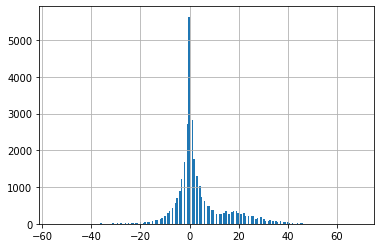

In [36]:
dfTrainsLearn['nextSpeed'].hist(bins=200)

In [37]:
dfTrainsLearn['nextBeop'].unique()

array([ nan,   1.,   4.,  16.,  21.,  14.,  17.,  -2., -13.,  12.,   6.,   2.,  -1.,   0.,  -4.,  -3.,  -7., -17.,  -5.,   3., -10., -11.,   7.,  18.,  10.,   5., -21.,  13.,  -6.,   9., -19.,  -8.,
        22., -12.,   8.,  11.,  -9., -22.,  15., -14., -23., -20.,  19., -26.,  20., -15., -18., -25.,  23.,  25., -41., -33., -34., -16.,  26.,  24.,  29., -24.,  31.,  32.,  27., -28., -30.,  30.,
        28., -32.,  33., -36.,  46.,  52.,  53., -31., -27., -40.,  38.,  43.,  45.,  40.,  39., -43.,  36.,  63.,  41., -29.,  48., -45.,  68.,  65.,  35., -39., -35., -49., -55., -42., -38.,  34.,
       -37., -47.])

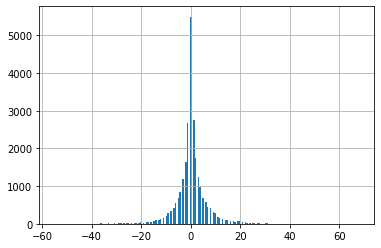

In [38]:
dfTrainsLearn['nextBeop'].hist(bins=200)

Drop some values we are not using at the moment not needed

In [39]:
dfTrainsNextBeop = dfTrainsLearn['nextBeop']

In [40]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'nextBeop',
                                            # 'lastReportedPosition.precedingSignalState.currentStateTime', 
                                            # 'lastReportedPosition.nextSignalState.previousSignalState', 
                                            # 'lastReportedPosition.nextSignalState.currentStateTime', 
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

In [41]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
1,AMTK179,UP,,AMT1,...,False,False,False,1.655761e+09
2,AMTK179,UP,,AMT1,...,False,False,False,1.655761e+09
3,AMTK186,UP,,AMT1,...,False,False,False,1.655938e+09
4,AMTK186,UP,,AMT1,...,False,False,False,1.655938e+09
5,AMTK186,UP,,AMT1,...,False,False,False,1.655938e+09
...,...,...,...,...,...,...,...,...,...
33627,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09
33628,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09
33629,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09
33630,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09


In [42]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[100])

(31554, 47)
(33632,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31554 entries, 1 to 33631
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            31554 non-null  object        
 1   trainId.trainSCAC                                              31554 non-null  object        
 2   trainId.trainSection                                           31554 non-null  object        
 3   trainId.trainSymbol                                            31554 non-null  object        
 4   trainId.trainDate                                              31554 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  31554 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            31554 non-

# Use Decision Tree to predict speed in 1 mile

In [43]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

In [44]:
print (dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count())


lastReportedPosition.positionTimeDayofyear
171    4009
172    4365
173    3999
174    5016
175    4619
176    4398
177    4648
178     500
Name: lastReportedPosition.positionTimeDayofyear, dtype: int64


In [45]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] < 175 )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [46]:
dep_var = 'nextSpeed'

In [47]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [48]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [49]:
len(to.train),len(to.valid)

(17389, 14165)

In [50]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,mpIncr,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.ownershipCode,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,aotuTrainData.eventCode,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,milepost,locomotiveCount,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextSpeed
1,AMTK179,UP,,AMT1,2022-06-19,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,10,764.986572,1.0,14.0,2.0,3.0,4460000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,20,0,171,1.655761e+09,4.0
2,AMTK179,UP,,AMT1,2022-06-19,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,10,764.994873,1.0,14.0,2.0,3.0,4460000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,20,0,171,1.655761e+09,4.0
3,AMTK186,UP,,AMT1,2022-06-21,106,TO_S_UP_MAINLINE,True,#na#,#na#,2022,6,False,False,False,False,False,False,8,764.869080,1.0,14.0,2.0,3.0,7140000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,22,2,173,1.655938e+09,9.0
4,AMTK186,UP,,AMT1,2022-06-21,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,10,764.987610,1.0,14.0,2.0,3.0,7140000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,22,2,173,1.655938e+09,8.0
5,AMTK186,UP,,AMT1,2022-06-21,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,10,764.996582,1.0,14.0,2.0,3.0,7140000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,22,2,173,1.655938e+09,8.0
8,AMTK186,UP,,AMT2,2022-06-19,106,WEST MAIN,False,#na#,#na#,2022,6,False,False,False,False,False,False,18,766.930176,1.0,14.0,2.0,3.0,9820000.0,77760.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,25,22,2,173,1.655857e+09,2.0
9,AMTK186,UP,,AMT2,2022-06-19,106,WEST MAIN,False,#na#,#na#,2022,6,False,False,False,False,False,False,19,766.797607,1.0,14.0,2.0,3.0,9820000.0,77760.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,25,22,2,173,1.655857e+09,-1.0
33,BNSF3185,UP,,QNSIJJ,2022-06-21,106,WEST MAIN,False,#na#,#na#,2022,6,False,False,False,False,False,False,10,766.930603,2.0,12.0,2.0,3.0,125003368.0,630310.0,6916630.0,16010.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,25,23,3,174,1.655972e+09,-1.0
34,BNSF3185,UP,,QNSIJJ,2022-06-21,106,WEST MAIN,False,#na#,#na#,2022,6,False,False,False,False,False,False,11,766.465271,2.0,12.0,2.0,3.0,125003368.0,630310.0,6916630.0,16010.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,25,23,3,174,1.655972e+09,-2.0
36,BNSF3185,UP,,QNSIJJ,2022-06-21,106,MAIN,False,#na#,#na#,2022,6,False,False,False,False,False,False,9,766.048401,2.0,12.0,2.0,3.0,125003368.0,630310.0,6916630.0,16010.0,65535.0,0

In [51]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [52]:
to = fastai.load_pickle('/tmp/to.pkl')

In [53]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [54]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

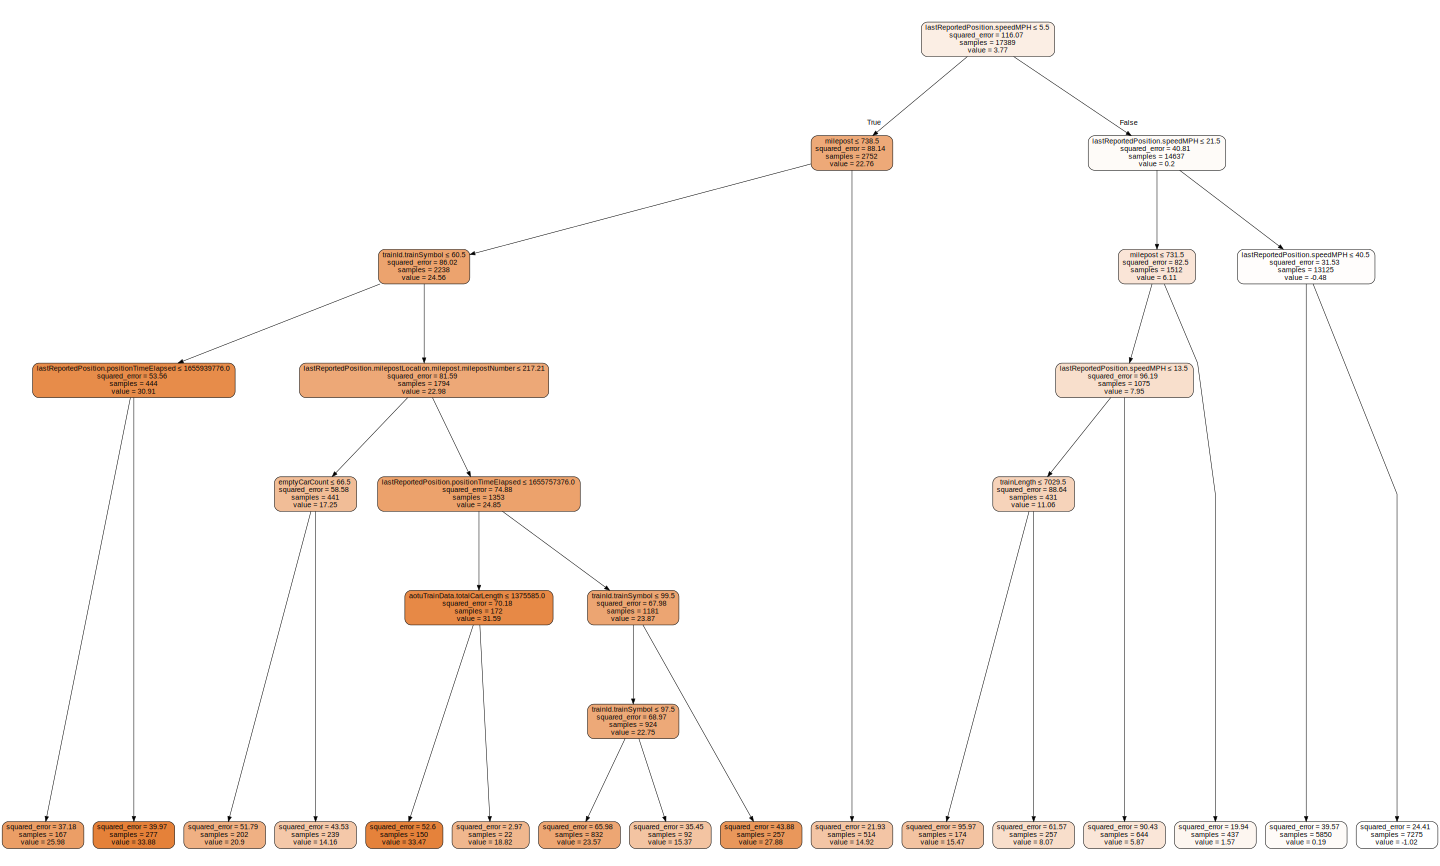

In [55]:
fastai.draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

In [56]:
m = DecisionTreeRegressor(min_samples_leaf=10)
m.fit(xs, y);

In [57]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [58]:
m_rmse(m, xs, y)

4.288212

In [59]:
m_rmse(m, valid_xs, valid_y)

8.011705

In [60]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [61]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
18,lastReportedPosition.speedMPH,0.748393
19,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.064171
39,milepost,0.041393
45,lastReportedPosition.positionTimeElapsed,0.031422
3,trainId.trainSymbol,0.027103
37,trainLength,0.019862
0,ptcLeadLocomotiveId,0.011271
25,aotuTrainData.totalCarLength,0.009502
36,emptyCarCount,0.006179
7,mpIncr,0.005814


Our first result! It appears the previous speed is so heavily influencing the next speed, it swamps everything else.

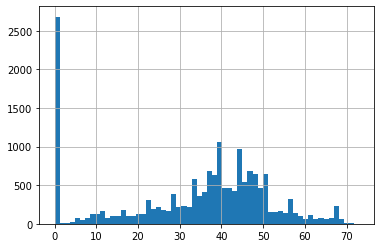

In [62]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=60)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


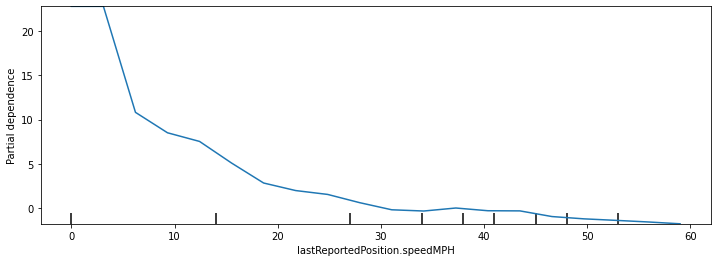

In [63]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

This is sort of a dur moment, saying "Speeds don't change a lot one milepost to the next".  

#Random Forest

In [64]:
def randomForest(xs, y, n_estimators=50, max_samples=2500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [65]:
m = randomForest(xs, y);

In [66]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(5.047948, 6.097554)

In [67]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

In [68]:
r_mse(preds.mean(0), valid_y)

6.097554

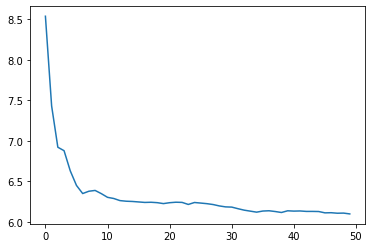

In [69]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [70]:
r_mse(m.oob_prediction_, y)

5.353549

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [71]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

In [72]:
preds.shape

(50, 14165)

In [73]:
preds_std = preds.std(0)

In [74]:
preds_std[:5]

array([4.8723886 , 4.8548263 , 4.82099863, 4.97148141, 4.9471824 ])

In [75]:
print(preds.mean(0)[:10])
print(valid_y[:10])

[2.1135101  1.98231962 2.98106566 1.82365296 4.37020491 4.18538745 4.24188745 3.09280808 3.18998268 3.38083189]
14   -4.0
15   -3.0
20    8.0
21   -1.0
26    9.0
27    9.0
28    9.0
38   -1.0
39    0.0
40   -4.0
Name: nextSpeed, dtype: float32


# FEATURE Importance

In [76]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
18,lastReportedPosition.speedMPH,0.665585
19,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.063574
7,mpIncr,0.053030
39,milepost,0.040917
45,lastReportedPosition.positionTimeElapsed,0.028325
37,trainLength,0.016633
3,trainId.trainSymbol,0.015067
38,trailingTonnage,0.013540
35,loadedCarCount,0.013079
25,aotuTrainData.totalCarLength,0.010625


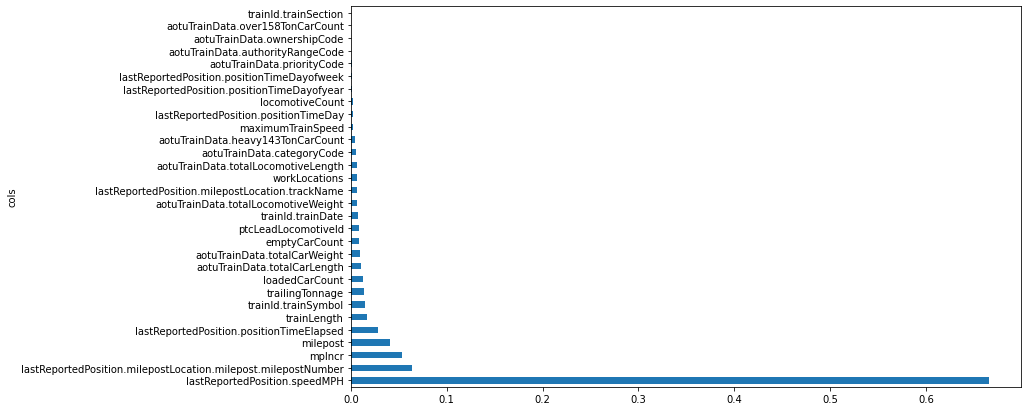

In [77]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [78]:
to_keep = fi[fi.imp>0.002].cols
len(to_keep)

22

In [79]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [80]:
m = randomForest(xs_imp, y)

In [81]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(5.057965, 6.036259)

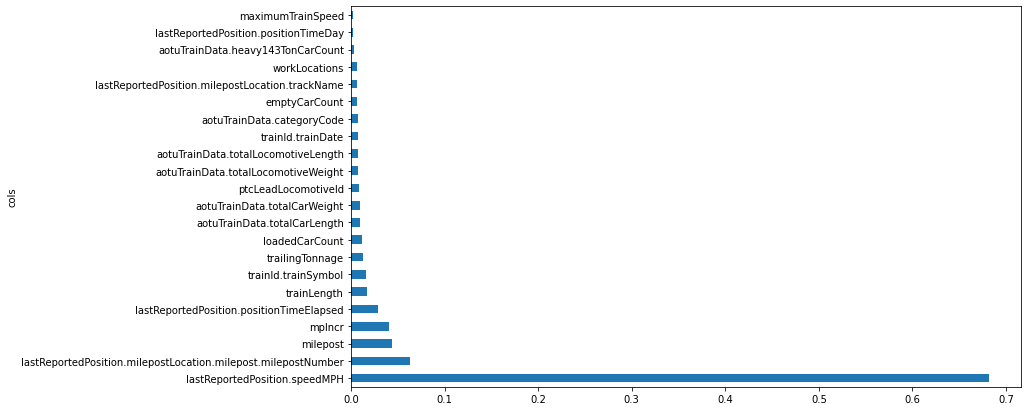

In [82]:
plot_fi(rf_feat_importance(m, xs_imp));

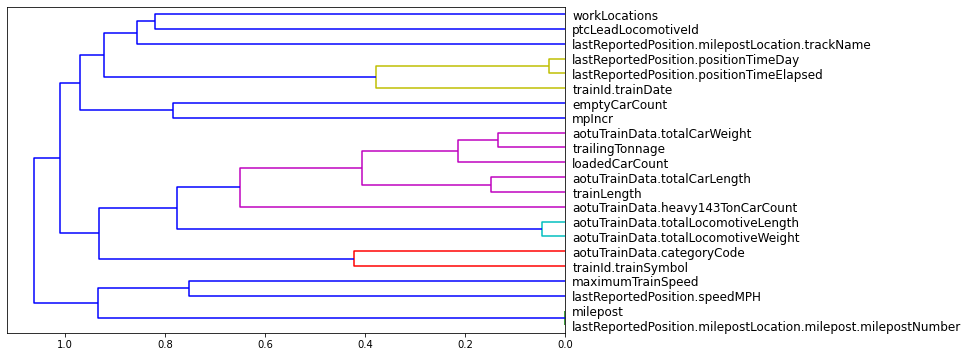

In [83]:
fastai.cluster_columns(xs_imp)